In [1]:
# Initialize the notebook
using Pkg
Pkg.instantiate()
Pkg.activate("..")
#include("../src/Particles.jl")
using Particles
using Random
using Plots
using Zarr
using ZipFile

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

  Activating project at `j:\Master_Thesis\particles.jl`

In [2]:
# unzip the test data

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end


if !isdir("./data/locxxz_fullgrid_map.zarr") 
    unzip("./data/locxxz_fullgrid_map.zip","./data")
end

In [42]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 10 # number of particles
d["nparticles"] = n
# problem specific settings
x_release = 150
d["x_release"] = x_release
y_release = 0.5
d["y_release"] = y_release 
z_min_release = -8.0  
d["z_min_release"] = z_min_release
z_max_release = -2.0
d["z_max_release"] = z_max_release


# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] .= x_release
p[2, :] .= y_release # y
p[3, :]  = range(z_min_release,z_max_release, length=n)
p[4, :] .= 0.0 # age
d["particles"] = p # initial values
# simulation time
d["time_direction"] = :forwards
dt = 15.0
d["dt"] = dt     #time-step
d["tstart"] = 0.0 #start after 2 cycles
d["tend"]   = 300.0
tstart=d["tstart"]
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:dt:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_tidal_flume.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:dt:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(tstart:dt:tend)

d #show configuration

Dict{String, Any} with 28 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [150.0 150.0 … 150.0 150.0; 0.5 0.5 … 0.5 0.5; -8.0…
  "nparticles"           => 10
  "plot_maps_times"      => [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 12…
  "dt"                   => 15.0
  "tend"                 => 300.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_tidal_flume.nc"
  "z_min_release"        => -8.0
  "variables"            => ["x", "y", "z", "age"]
  "keep_particle_times"  => [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 12…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "z_max_release"        => -2.0
  "plot_maps_func"       => plot_maps_xz
  "coordinates"          => "projected"
  ⋮                      => ⋮

In [29]:
d["all_particles"]

Any[]

In [5]:
# careful to the conflict in the name of variables
# mainly useful for reading the file using NETCDF package
"""
using NetCDF
d=NetCDF.open("locxx_map.nc")
@show d.vars
z= d["mesh2d_layer_z"][:]
@show z' # z is a 1D array from -10 to 0
ts = d["time"][:] # d["time"].atts
@show ts' # ts is a 1D array with the time steps in seconds
"""

"using NetCDF\nd=NetCDF.open(\"locxx_map.nc\")\n@show d.vars\nz= d[\"mesh2d_layer_z\"][:]\n@show z' # z is a 1D array from -10 to 0\nts = d[\"time\"][:] # d[\"time\"].atts\n@show ts' # ts is a 1D array with the time steps in seconds\n"

In [30]:
using NetCDF
# open the netcdf file with dflow.jl
dflow_map=load_nc_info("data",r"locxx_map.nc")
t0=get_reftime(dflow_map)
itime=10
u_velocity=load_nc_map_slice(dflow_map,"mesh2d_ucx",itime)
v_velocity=load_nc_map_slice(dflow_map,"mesh2d_ucy",itime)
times = get_times(dflow_map,t0)
@show times' # 0 to 600 seconds

nothing

┌ Info: data\locxx_map.nc
└ @ Particles j:\Master_Thesis\particles.jl\src\dflow.jl:27


times' = Any[0.0 30.00000000000005 59.99999999999979 89.9999999999995 119.99999999999922 149.99999999999997 180.0000000000011 210.00000000000225 240.00000000000338 270.0000000000045 300.0000000000056 330.00000000000676 360.0000000000079 390.00000000000904 420.0000000000102 450.0000000000113 480.00000000001245 510.0000000000136 540.0000000000094 570.0000000000049 600.0]


In [43]:
Zarr_data = ZarrData("./data","locxxz_fullgrid_map.zarr")
t0=get_reftime(Zarr_data)
ts = get_times(Zarr_data, t0)
#display(ts)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
s=initialize_interpolation(Zarr_data,"salinity",t0)
v=initialize_interpolation(Zarr_data,"y_velocity",t0)

#function v(x,y,z,t) #not intersted in the lateral movement of particles
#    return 0.0
#end

function w(x,y,z,t) #the module for vertical tracking is not done now
    return 0.0
end

nothing

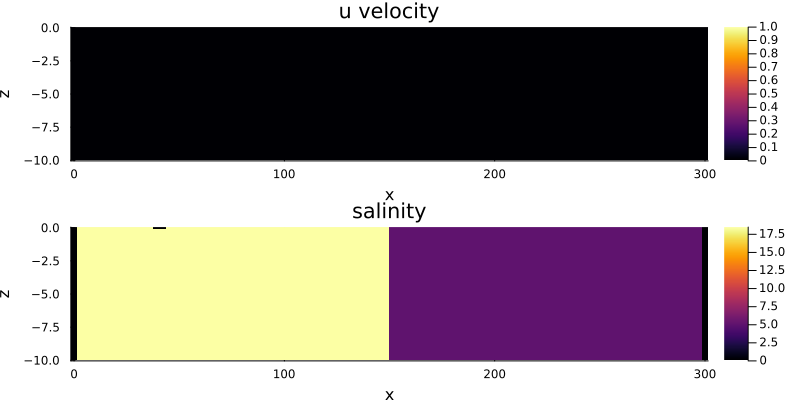

In [8]:
x_left = 0.0
x_middle = 150.0
x_right = 300.0
y_middle = 0.5
z_surface = 0.0
z_middle = -5.0
z_bottom = -10.0
t=0

# grid for plotting only
x_points = range(x_left,stop=x_right,length=100)
z_points = range(z_bottom,stop=z_surface,length=100)
u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity

l = @layout([a; b])
p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity")
p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity")
plot(p1,p2,layout=l,size=(800,400))

┌ Info: Saved animation to j:\Master_Thesis\particles.jl\case_lock_exchange\locxx_test.gif
└ @ Plots C:\Users\hugo1111234\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("j:\\Master_Thesis\\particles.jl\\case_lock_exchange\\locxx_test.gif")
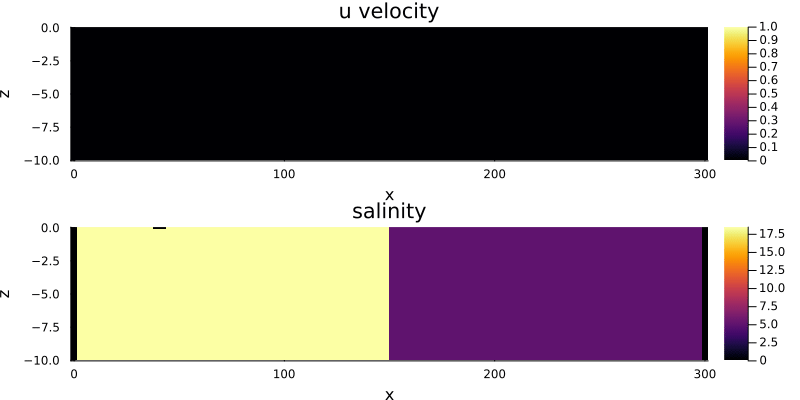

In [9]:
t_start=0.0
t_step=15.0
t_stop=300.0
anim = @animate for t in range(t_start, stop=t_stop-t_step, step=t_step)
    x_points = range(x_left,stop=x_right,length=100)
    z_points = range(z_bottom,stop=z_surface,length=100)
    u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity

    l = @layout([a; b])
    p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity")
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity")
    plot(p1,p2,layout=l,size=(800,400))
end
gif(anim, "./locxx_test.gif",fps=4)

In [44]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes as ds the function f in the equation ds=f(s,t)dt+g(s,t)dw 
for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = w(x, y, z, t)
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

#
# TODO: add function g! to simulate diffusion to simulation routine
#

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = 0.0
   # dy/dt=v
    ∂s.y = 0.0
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 0.0
end
d["g"] = g!

g! (generic function with 1 method)

In [45]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  165.0, 180.0, 195.0, 210.0, 225.0, 240.0, 255.0, 270.0, 285.0

, 300.0]
interrupt simulation for output at t = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  165.0, 180.0, 195.0, 210.0, 225.0, 240.0, 255.0, 270.0, 285.0, 300.0]
Simulation from time 0.0 s to 300.0 s since 2000-01-01T00:00:00 since 2000-01-01T00:00:00
t=0.0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%
t=0.0 -> 15.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:15 : 5.0%

t=15.0 -> 30.0  : 2000-01-01T00:00:15 -> 2000-01-01T00:00:30 : 10.0%
t=30.0 -> 45.0  : 2000-01-01T00:00:30 -> 2000-01-01T00:00:45 : 15.0%
t=45.0 -> 60.0  : 2000-01-01T00:00:45 -> 2000-01-01T00:01:00 : 20.0%
t=60.0 -> 75.0  : 2000-01-01T00:01:00 -> 2000-01-01T00:01:15 : 25.0%
t=75.0 -> 90.0  : 2000-01-01T00:01:15 -> 2000-01-01T00:01:30 : 30.0%
t=90.0 -> 105.0  : 2000-01-01T00:01:30 -> 2000-01-01T00:01:45 : 35.0%
t=105.0 -> 120.0  : 2000-01-01T00:01:45 -> 2000-01-01T00:02:00 : 40.0%
t=120.0 -> 135.0  : 2000-01-01T00:02:00 -> 2000-01-01T00:02:15 : 45.0%
t=135.0 -> 150.0  : 2000-01-01T00:02:15 -> 2000-01-01T00:02:30 : 50.0%
t=150.0 -> 165.0  : 2000-01-01T00:02:30 -> 2000-01-01T00:02:45 : 55.0%
t=165.0 -> 180.0  : 2000-01-01T00:02:45 -> 2000-01-01T00:03:00 : 60.0%


t=180.0 -> 195.0  : 2000-01-01T00:03:00 -> 2000-01-01T00:03:15 : 65.0%
t=195.0 -> 210.0  : 2000-01-01T00:03:15 -> 2000-01-01T00:03:30 : 70.0%
t=210.0 -> 225.0  : 2000-01-01T00:03:30 -> 2000-01-01T00:03:45 : 75.0%
t=225.0 -> 240.0  : 2000-01-01T00:03:45 -> 2000-01-01T00:04:00 : 80.0%
t=240.0 -> 255.0  : 2000-01-01T00:04:00 -> 2000-01-01T00:04:15 : 85.0%
t=255.0 -> 270.0  : 2000-01-01T00:04:15 -> 2000-01-01T00:04:30 : 90.0%
t=270.0 -> 285.0  : 2000-01-01T00:04:30 -> 2000-01-01T00:04:45 : 95.0%
t=285.0 -> 300.0  : 2000-01-01T00:04:45 -> 2000-01-01T00:05:00 : 100.0%


  0.603407 seconds (135.07 k allocations: 32.489 MiB, 7.43% gc time, 32.12% compilation time: 100% of which was recompilation)


┌ Info: Saved animation to j:\Master_Thesis\particles.jl\case_lock_exchange\locxx_test.gif
└ @ Plots C:\Users\hugo1111234\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("j:\\Master_Thesis\\particles.jl\\case_lock_exchange\\locxx_test.gif")
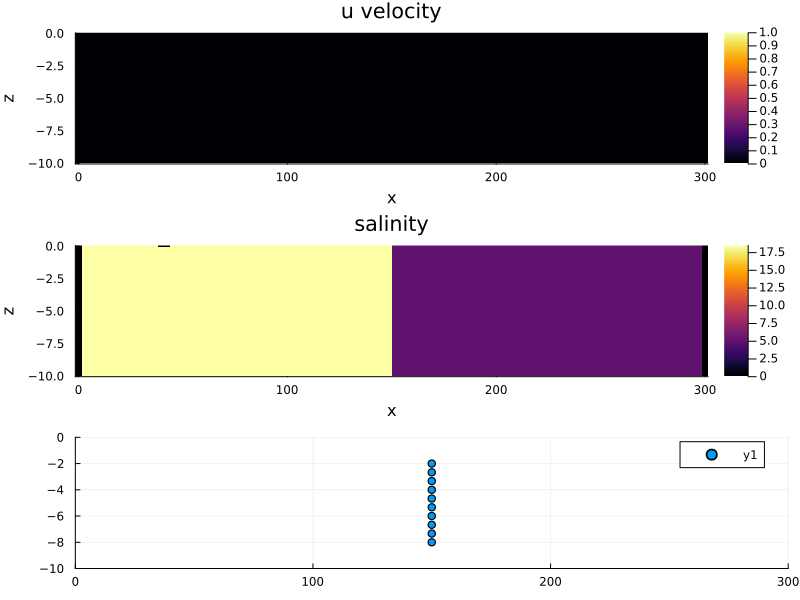

In [49]:
# for output and plotting: consistent with 
t_start=0.0
t_step=2.0*dt
t_stop=300.0
anim = @animate for t in range(t_start, stop=t_stop-t_step, step=t_step)
    x_points = range(x_left,stop=x_right,length=100)
    z_points = range(z_bottom,stop=z_surface,length=100)
    u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity

    l = @layout([a; b; c])
    p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity")
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity")
    
    # add particles
    itime = findfirst(x->x==t, d["keep_particle_times"]) #itime=findmin(abs.(t.-d["keep_particle_times"]))[2]
    p3=scatter(d["all_particles"][itime][1,:],d["all_particles"][itime][3,:],clims=(0,3.0),xlims=(x_left,x_right),ylims=(z_bottom,z_surface))

    plot(p1,p2,p3,layout=l,size=(800,600))
    #plot(plot(p1,p3),plot(p2,p3),layout=l,size=(800,400))
end
gif(anim, "./locxx_test.gif",fps=2)